In [32]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Set device to CPU
device = torch.device("cpu")

In [34]:
# Load the pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [35]:
# Define the transform for the input image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [36]:
# Mapping for COCO classes
COCO_CLASSES = {i: class_name for i, class_name in enumerate([
'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
])}

In [37]:
def segment_object(image_path, class_name):
    # Load image
    image = cv2.imread(image_path)
    original_height, original_width = image.shape[:2]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare the image for the model
    input_tensor = transform(image_rgb)
    input_batch = input_tensor.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    # Create a mask for the desired class
    class_id = list(COCO_CLASSES.values()).index(class_name)
    mask = (output_predictions == class_id).astype(np.uint8)

    # Resize mask to original image dimensions
    mask_resized = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    return image_rgb, mask_resized


In [38]:
def rotate_object(image, mask, azimuth, polar):
    # Create a mask of the object
    object_mask = np.zeros_like(image)
    object_mask[mask > 0] = image[mask > 0]  # Mask applied to the object

    # Calculate rotation parameters
    angle = azimuth  # For azimuth, we rotate around the z-axis
    center = (object_mask.shape[1] // 2, object_mask.shape[0] // 2)
    
    # Rotate the object
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_object = cv2.warpAffine(object_mask, M, (object_mask.shape[1], object_mask.shape[0]))

    # Combine with the original image
    combined_image = np.where(rotated_object > 0, rotated_object, image)
    
    return combined_image

In [39]:
def save_segmented_image(image, mask, output_path):
    # Create a red mask overlay
    red_mask = np.zeros_like(image)
    red_mask[mask > 0] = [255, 0, 0]  # Red color

    # Combine the original image with the red mask
    segmented_image = cv2.addWeighted(image, 0.5, red_mask, 0.5, 0)
    
    # Save the segmented image
    cv2.imwrite(output_path, segmented_image)


Output saved to final_output.png
Segmented image saved to segmented_output.png


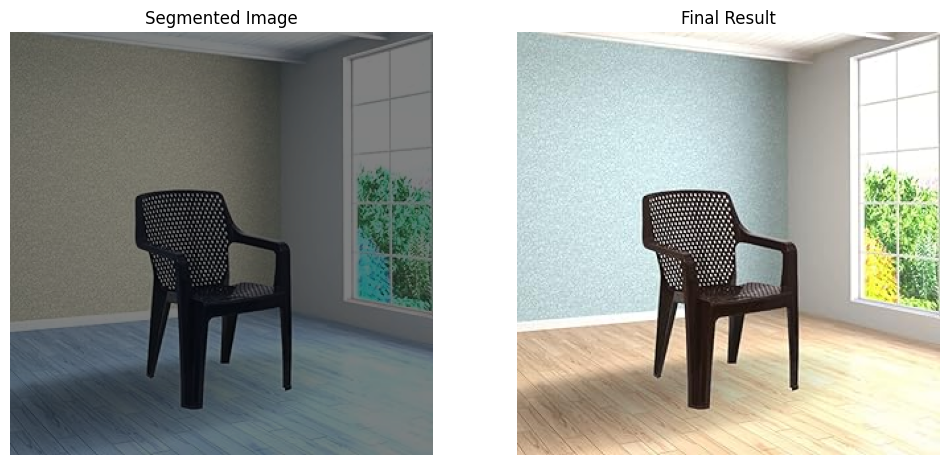

In [40]:
# Set the parameters
image_path = 'chair.jpg'  # Path to your single input image
class_name = 'chair'       # Class name to detect
azimuth = 72               # Azimuth rotation in degrees
polar = 0                  # Polar rotation in degrees
output_image_path = 'final_output.png'    # Path to save the final image
segmented_image_path = 'segmented_output.png'  # Path to save the segmented image

# Segment the object
original_image, mask = segment_object(image_path, class_name)

# Save the segmented image
save_segmented_image(original_image, mask, segmented_image_path)

# Rotate the object
result_image = rotate_object(original_image, mask, azimuth, polar)

# Save the final result
cv2.imwrite(output_image_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
print(f"Output saved to {output_image_path}")
print(f"Segmented image saved to {segmented_image_path}")

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Segmented Image")
plt.imshow(cv2.cvtColor(cv2.imread(segmented_image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Final Result")
plt.imshow(cv2.cvtColor(cv2.imread(output_image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Segmented 0 pixels for class 'car'.


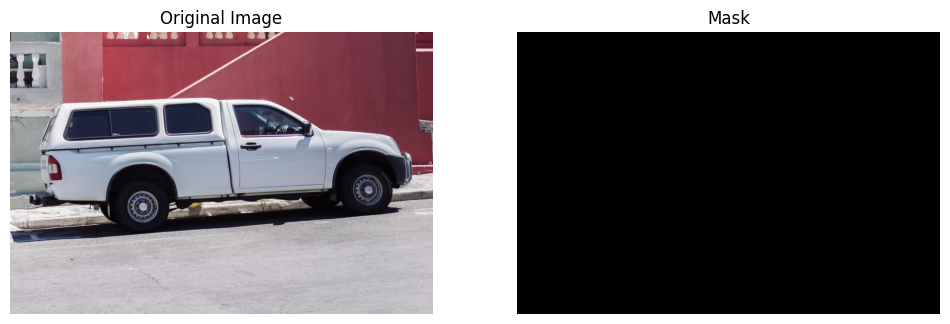

Output saved to final_output.png
Segmented image saved to segmented_output.png


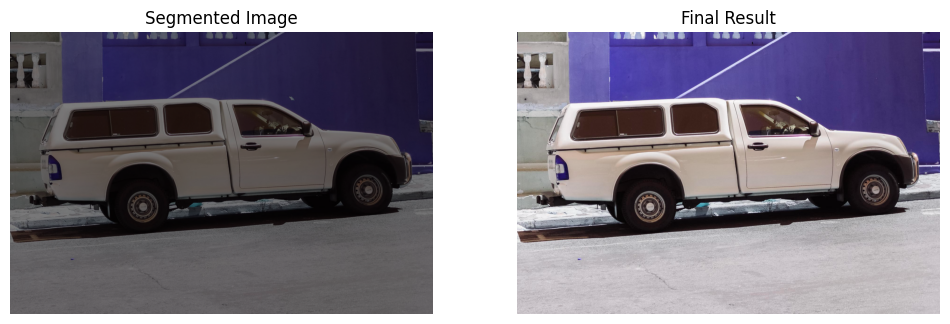

In [44]:
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set device to CPU
device = torch.device("cpu")

# Load the pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()
model.to(device)

# COCO class names
COCO_CLASSES = {
    0: "person", 1: "bicycle", 2: "car", 3: "motorcycle", 4: "airplane",
    5: "bus", 6: "train", 7: "truck", 8: "boat", 9: "traffic light",
    10: "fire hydrant", 11: "stop sign", 12: "parking meter", 13: "bench",
    14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep",
    19: "cow", 20: "elephant", 21: "bear", 22: "zebra", 23: "giraffe",
    24: "backpack", 25: "umbrella", 26: "handbag", 27: "tie",
    28: "suitcase", 29: "frisbee", 30: "skis", 31: "snowboard",
    32: "sports ball", 33: "kite", 34: "baseball bat", 35: "baseball glove",
    36: "skateboard", 37: "surfboard", 38: "tennis racket", 39: "bottle",
    40: "wine glass", 41: "cup", 42: "fork", 43: "knife",
    44: "spoon", 45: "bowl", 46: "banana", 47: "apple",
    48: "sandwich", 49: "orange", 50: "broccoli", 51: "carrot",
    52: "hot dog", 53: "pizza", 54: "donut", 55: "cake",
    56: "chair", 57: "couch", 58: "potted plant", 59: "bed",
    60: "dining table", 61: "toilet", 62: "TV", 63: "laptop",
    64: "mouse", 65: "remote", 66: "keyboard", 67: "cell phone",
    68: "microwave", 69: "oven", 70: "toaster", 71: "sink",
    72: "refrigerator", 73: "book", 74: "clock", 75: "vase",
    76: "scissors", 77: "teddy bear", 78: "hair drier", 79: "toothbrush"
}

# Define the transform for the input image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_object(image_path, class_name):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}. Check the file path.")
        return None, None
    
    original_height, original_width = image.shape[:2]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare the image for the model
    input_tensor = transform(image_rgb)
    input_batch = input_tensor.unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    # Check class ID
    try:
        class_id = list(COCO_CLASSES.values()).index(class_name)
    except ValueError:
        print(f"Class '{class_name}' not found in COCO classes.")
        return image_rgb, None

    # Create a mask for the desired class
    mask = (output_predictions == class_id).astype(np.uint8)

    # Resize mask to original image dimensions
    mask_resized = cv2.resize(mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Check the number of pixels segmented
    print(f"Segmented {np.sum(mask_resized)} pixels for class '{class_name}'.")

    return image_rgb, mask_resized

def rotate_object(image, mask, azimuth, polar):
    # Create a mask of the object
    object_mask = np.zeros_like(image)
    object_mask[mask > 0] = image[mask > 0]  # Mask applied to the object

    # Calculate rotation parameters
    angle = azimuth  # For azimuth, we rotate around the z-axis
    center = (object_mask.shape[1] // 2, object_mask.shape[0] // 2)
    
    # Rotate the object
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_object = cv2.warpAffine(object_mask, M, (object_mask.shape[1], object_mask.shape[0]))

    # Combine with the original image
    combined_image = np.where(rotated_object > 0, rotated_object, image)
    
    return combined_image

def save_segmented_image(image, mask, output_path):
    # Create a red mask overlay
    red_mask = np.zeros_like(image)
    red_mask[mask > 0] = [255, 0, 0]  # Red color

    # Combine the original image with the red mask
    segmented_image = cv2.addWeighted(image, 0.5, red_mask, 0.5, 0)
    
    # Save the segmented image
    cv2.imwrite(output_path, segmented_image)

# Set the parameters
image_path = 'dog.jpg'  # Path to your single input image (make sure it's a car image)
class_name = 'car'       # Class name to detect
azimuth = 72             # Azimuth rotation in degrees
polar = 0                # Polar rotation in degrees
output_image_path = 'final_output.png'    # Path to save the final image
segmented_image_path = 'segmented_output.png'  # Path to save the segmented image

# Segment the object
original_image, mask = segment_object(image_path, class_name)

# Check if the mask was successfully created
if mask is None:
    print("Segmentation failed. Exiting...")
else:
    # Debugging: Show the original image and the mask
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.show()

    # Save the segmented image
    save_segmented_image(original_image, mask, segmented_image_path)

    # Rotate the object
    result_image = rotate_object(original_image, mask, azimuth, polar)

    # Save the final result
    cv2.imwrite(output_image_path, cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    print(f"Output saved to {output_image_path}")
    print(f"Segmented image saved to {segmented_image_path}")

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(cv2.imread(segmented_image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Final Result")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    plt.axis('off')

    plt.show()
